In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Video
from matplotlib.animation import FFMpegFileWriter

In [2]:
omegas = np.random.rand(5)*10
omegas

array([4.1902311 , 5.2015754 , 3.19826551, 9.41681222, 4.64075275])

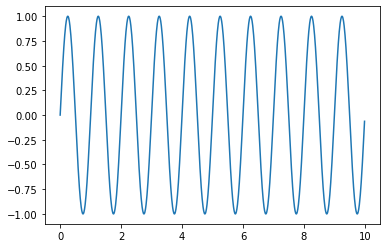

In [3]:
t = np.arange(0,10,0.01)
y = np.sin(2*np.pi*t)
plt.plot(t, y)

In [4]:
np.outer(t, omegas).sum(axis=-1).shape

(1000,)

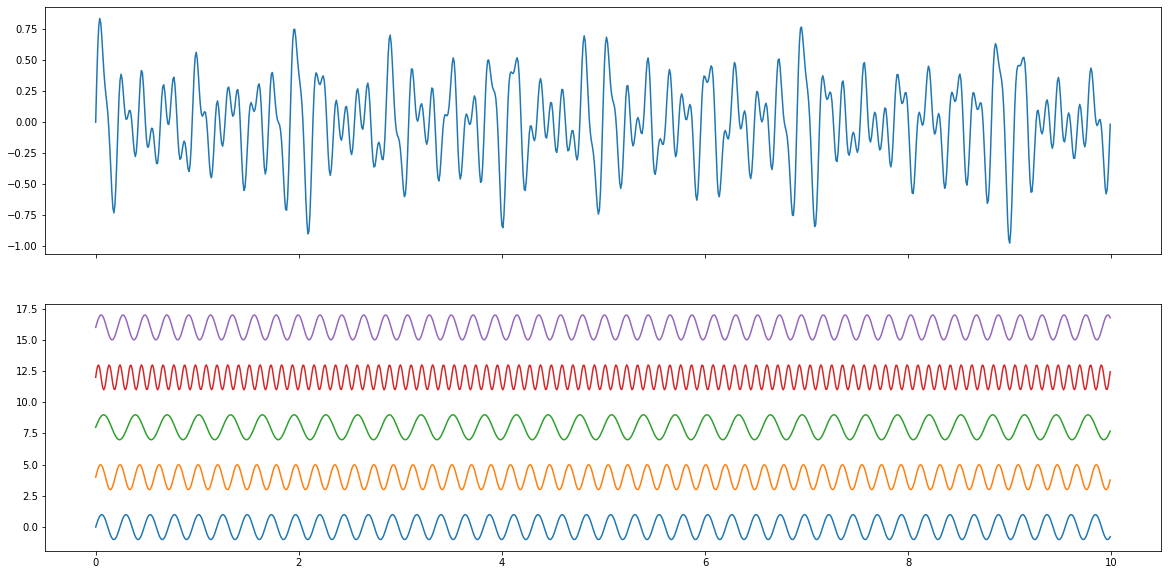

In [5]:
y_components = np.sin(2*np.pi*np.outer(t, omegas))
y = y_components.mean(axis=-1)
fig, ax = plt.subplots(2,1, sharex=True, figsize=(20, 10))
ax[0].plot(t, y)
for i, yi in enumerate(y_components.T):
    ax[1].plot(t, yi + 4*i)

In [6]:
np.fft.fft(y, 5)

array([ 2.52650409+0.j        , -0.74716938+0.58753352j,
       -0.51608267+0.1327843j , -0.51608267-0.1327843j ,
       -0.74716938-0.58753352j])

In [7]:
import pandas as pd

In [8]:
Y    = np.fft.rfft(y)
freq = np.fft.rfftfreq(len(y), t[1] - t[0])

df = pd.DataFrame({
    "Y": Y,
    "freq": freq
}).sort_values("freq")
df.head()

,Y,freq
0,1.480331+0.000000j,0.0
1,1.481021+0.001342j,0.1
2,1.483096+0.002713j,0.2
3,1.486566+0.004141j,0.3
4,1.491453+0.005656j,0.4


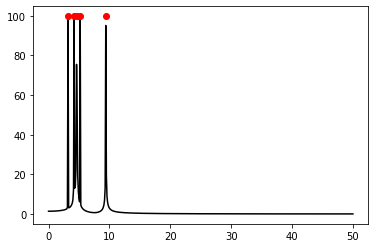

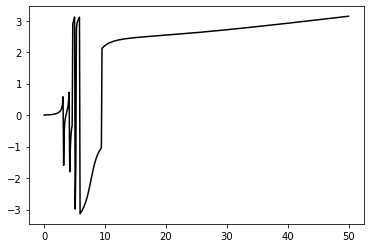

In [9]:
plt.figure()
plt.plot(df.freq, np.abs(df.Y), "-k")
plt.plot(omegas, np.max(np.abs(df.Y))*np.ones_like(omegas), "ro")
plt.figure()
plt.plot(df.freq, np.angle(df.Y), "-k")

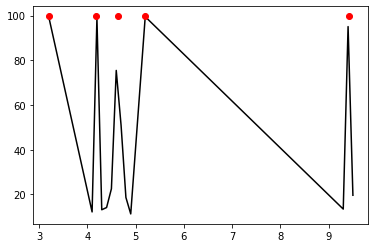

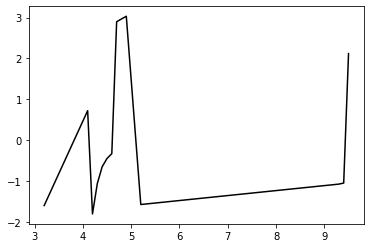

In [10]:
df_t = df[np.abs(df.Y) > 10]
plt.figure()
plt.plot(df_t.freq, np.abs(df_t.Y), "-k")
plt.plot(omegas, np.max(np.abs(df_t.Y))*np.ones_like(omegas), "ro")
plt.figure()
plt.plot(df_t.freq, np.angle(df_t.Y), "-k")

In [11]:
Y_clipped = Y.copy()
Y_clipped[np.abs(Y) < 20] = 0
y_ifft = np.fft.irfft(Y_clipped)

In [12]:
freq[np.abs(Y) > 10]

array([3.2, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.2, 9.3, 9.4,
       9.5])

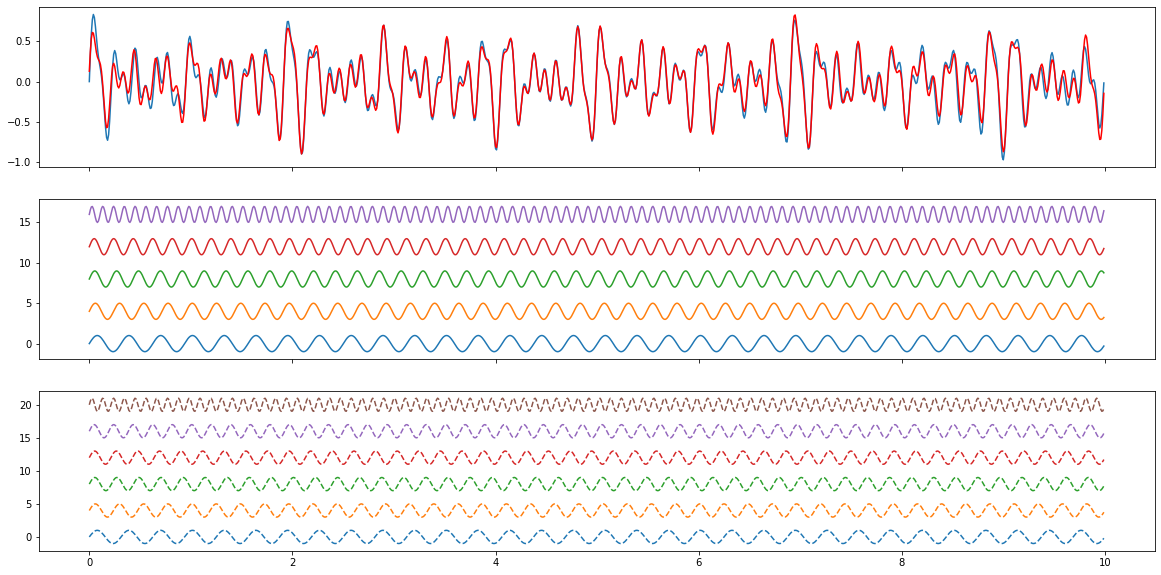

In [13]:
y_components = np.sin(2*np.pi*np.outer(t, omegas))
y = y_components.mean(axis=-1)
fig, ax = plt.subplots(3,1, sharex=True, figsize=(20, 10))
ax[0].plot(t, y)
ax[0].plot(t, y_ifft, "-r")
sorted_omegas = np.argsort(omegas)
for i, idx in enumerate(sorted_omegas):
    ax[1].plot(t, y_components[:, idx] + 4*i)

clipped_freq = freq[np.abs(Y) > 50]
for i, f in enumerate(sorted(clipped_freq)):
    ax[2].plot(t, np.sin(2*np.pi*f*t) + 4*i, linestyle="--")

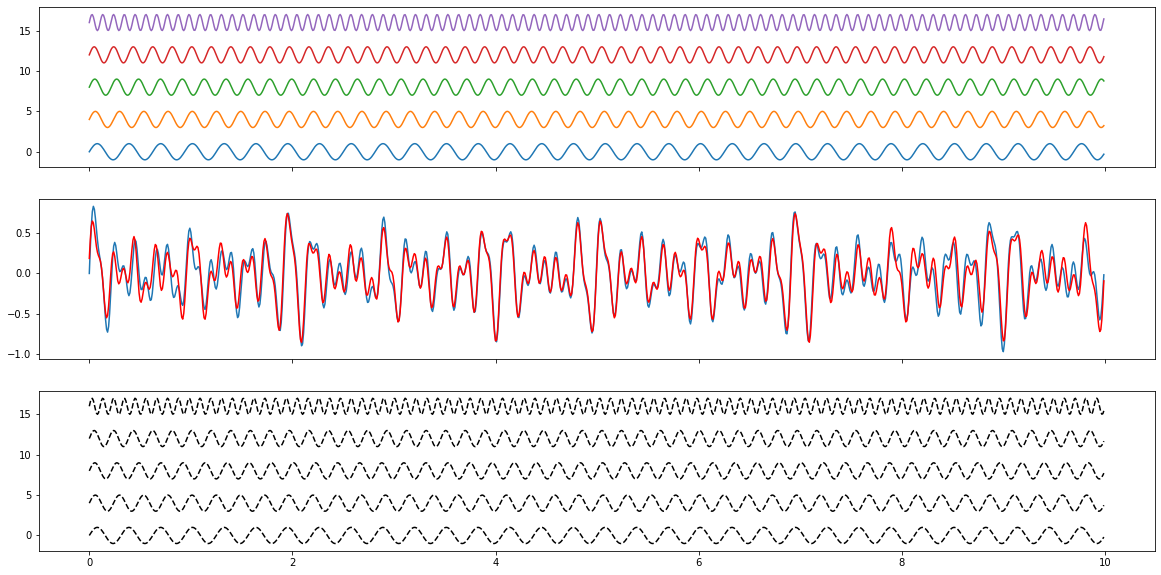

In [14]:
y_components = np.sin(2*np.pi*np.outer(t, omegas))
y = y_components.mean(axis=-1)
Y    = np.fft.rfft(y)
freq = np.fft.rfftfreq(len(y), t[1] - t[0])
Y_clipped = Y.copy()

sorted_indices = np.argsort(np.abs(Y_clipped), axis=None)[::-1]
ind = np.zeros(Y_clipped.shape)
ind[sorted_indices[:5]] = 1
Y_clipped = Y_clipped * ind
y_ifft = np.fft.irfft(Y_clipped)

fig, ax = plt.subplots(3,1, sharex=True, figsize=(20, 10))
ax[1].plot(t, y)
ax[1].plot(t, y_ifft, "-r")

sorted_omegas = np.argsort(omegas)
for i, idx in enumerate(sorted_omegas):
    ax[0].plot(t, y_components[:, idx] + 4*i)

#clipped_freq = freq[np.abs(Y) > 50]
clipped_freq = freq[sorted_indices[:5]]
for i, f in enumerate(sorted(clipped_freq)):
    ax[2].plot(t, np.sin(2*np.pi*f*t) + 4*i, linestyle="--", color="k")

In [15]:
def animate_1d_fft_reconstruction(t, omegas=None, video_file="fft.mp4"):
    if omegas is None:
        omegas = np.random.rand(5)*10
    y_components = np.sin(2*np.pi*np.outer(t, omegas))
    y = y_components.mean(axis=-1)
    Y    = np.fft.rfft(y)
    freq = np.fft.rfftfreq(len(y), t[1] - t[0])
    sorted_omegas = np.argsort(omegas)
    sorted_indices = np.argsort(np.abs(Y), axis=None)[::-1]

    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(3,1, sharex=True, figsize=(20, 10))
        ax[1].plot(t, y)
        fitted_wave,  = ax[1].plot([], [], "-r")

        sorted_omegas = np.argsort(omegas)
        for i, idx in enumerate(sorted_omegas):
            ax[0].plot(t, y_components[:, idx] + 4*i)

        moviewriter = FFMpegFileWriter(fps=10)
        with moviewriter.saving(fig, video_file, dpi=100):
            for i in (np.logspace(0, np.ceil(np.log10(sorted_indices.max())), 200)).astype("int"):
                Y_clipped = Y.copy()
                ind = np.zeros(Y_clipped.shape)
                ind[sorted_indices[:i]] = 1
                Y_clipped = Y_clipped * ind
                y_ifft = np.fft.irfft(Y_clipped)
                fitted_wave.set_data(t, y_ifft)
                clipped_freq = freq[sorted_indices[:i]]
                ax[2].clear()
                for i, f in enumerate(sorted(clipped_freq)):
                    ax[2].plot(t, np.sin(2*np.pi*f*t) + 4*i, linestyle="--", color="b")
                ax[2].set_title(f"Top {i} ({i*100/sorted_indices.max():.3f}%) FFT components")
                moviewriter.grab_frame()
    return video_file

Wall time: 3min 56s


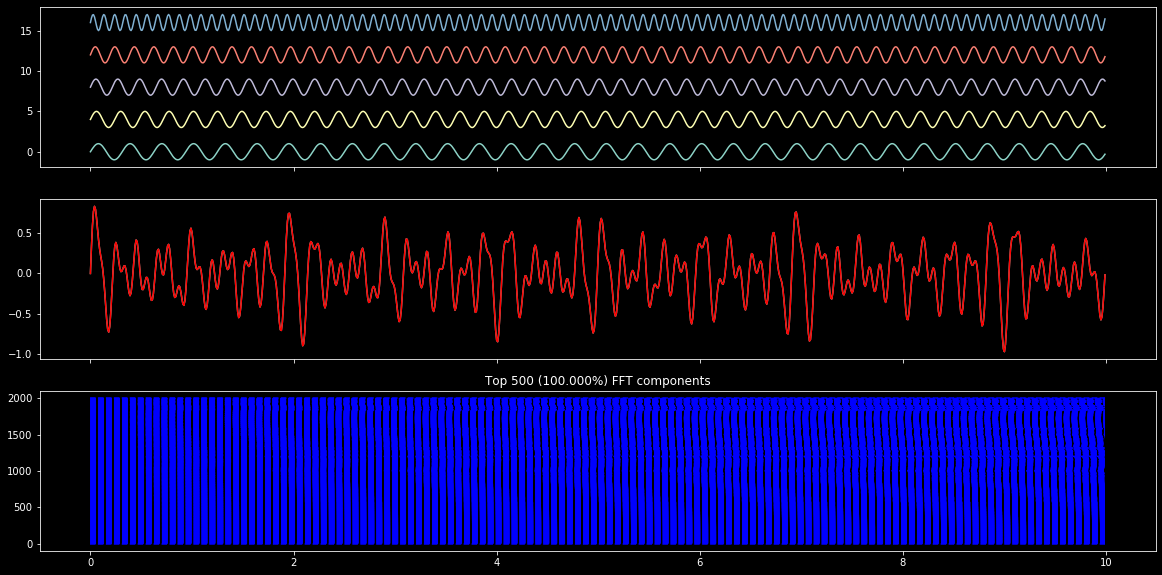

In [16]:
%%time
video_file="fft.mp4"
animate_1d_fft_reconstruction(t, omegas, video_file=video_file)
Video(video_file)

## Image compression

Based on https://www.youtube.com/watch?v=uB3v6n8t2dQ

In [17]:
img = plt.imread("C:/Users/shubh/Downloads/square.jpg")
#img = plt.imread("C:/Users/shubh/Downloads/Sharbat_Gula.jpg")

img.shape

(600, 600, 3)

In [18]:
img = np.ones((600, 600, 3))*255
img[150:450, 150] = 0
img[150:450, 450] = 0
img[150, 150:450] = 0
img[450, 150:450] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


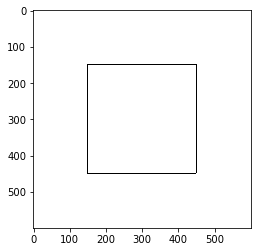

In [19]:
plt.imshow(img)

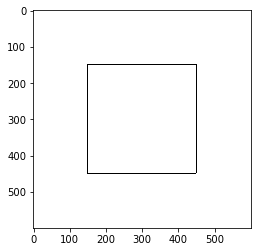

In [20]:
B = img.mean(-1)
plt.imshow(B, cmap="Greys_r")

In [21]:
Bt = np.fft.rfft2(B)
Bt.shape

(600, 301)

In [22]:
np.abs(Bt)

array([[9.14942550e+07, 9.74022688e+04, 1.52745000e+05, ...,
        1.52745000e+05, 2.55013982e+02, 1.52745000e+05],
       [9.74022688e+04, 2.55000000e+02, 9.74022688e+04, ...,
        9.74022688e+04, 2.55000000e+02, 9.74022688e+04],
       [1.52745000e+05, 9.74022688e+04, 2.55000000e+02, ...,
        2.55000000e+02, 2.55013982e+02, 2.55000000e+02],
       ...,
       [3.24659394e+04, 2.55000000e+02, 3.24659394e+04, ...,
        3.24659394e+04, 2.55000000e+02, 3.24659394e+04],
       [1.52745000e+05, 9.74022688e+04, 2.55000000e+02, ...,
        2.55000000e+02, 2.55013982e+02, 2.55000000e+02],
       [9.74022688e+04, 2.55000000e+02, 9.74022688e+04, ...,
        9.74022688e+04, 2.55000000e+02, 9.74022688e+04]])

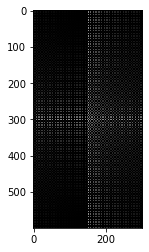

In [23]:
plt.imshow(np.log10(np.abs(np.fft.fftshift(Bt))), cmap="Greys_r")

F:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


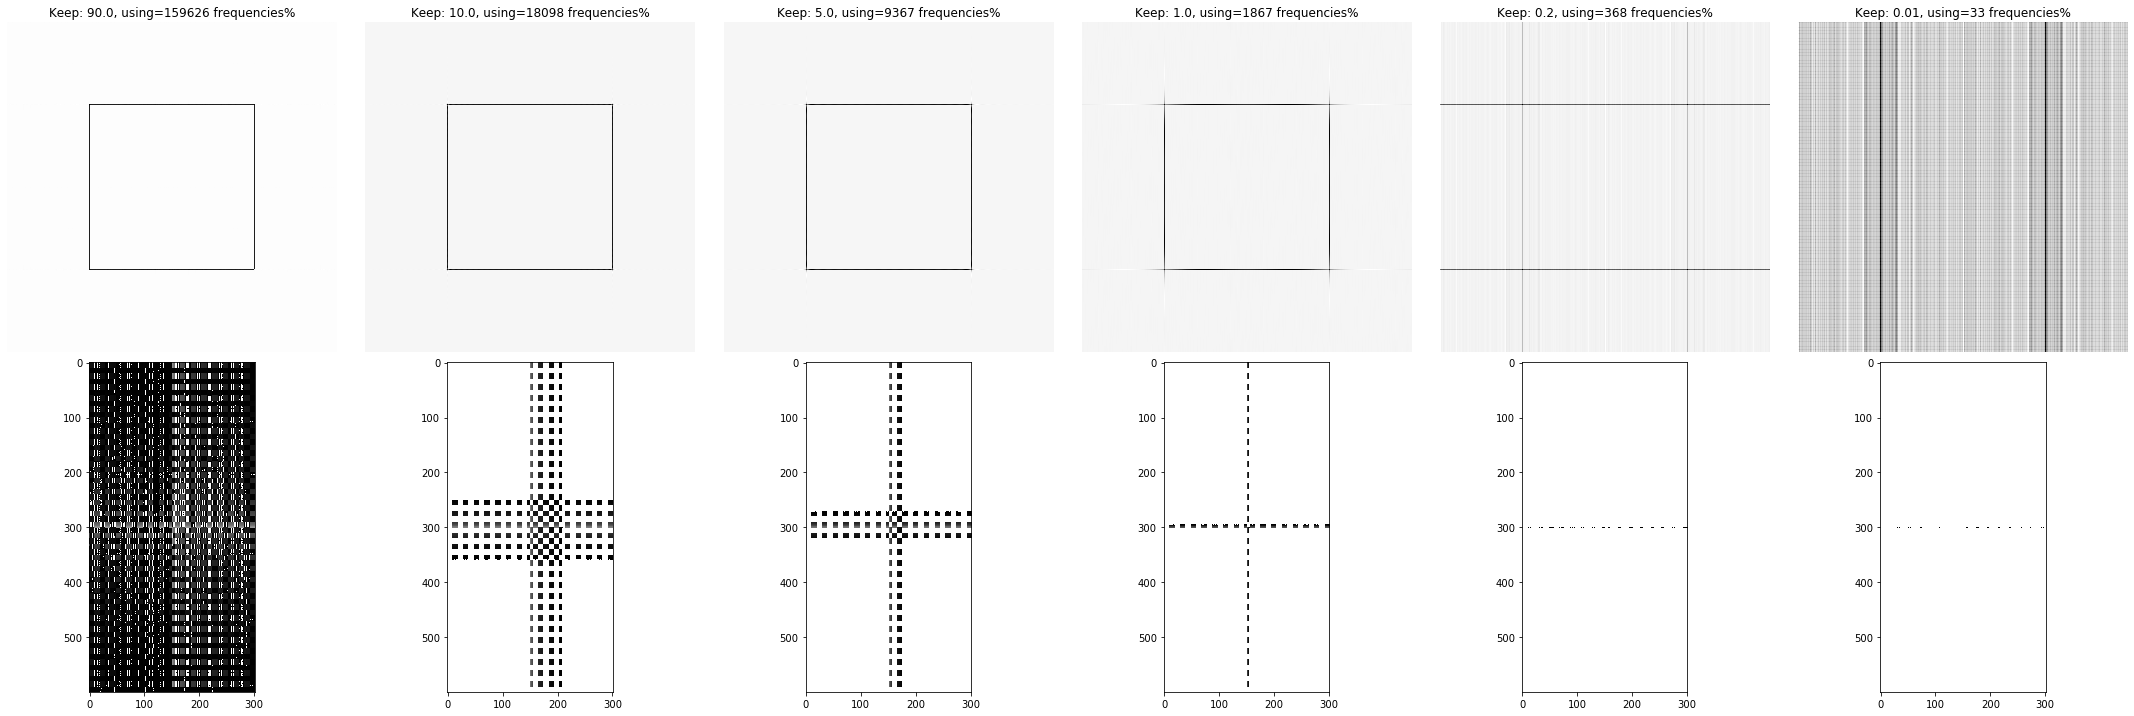

In [24]:
keep_values = [0.9, 0.1, 0.05, 0.01, 0.002, 1e-4,]
ncols = len(keep_values)

fig = plt.figure(figsize=(5*ncols, 10))

for i, keep in enumerate(keep_values):
    thresh = np.percentile(np.abs(Bt), (1-keep)*100)
    ind = np.abs(Bt) >= thresh
    Atlow = Bt * ind
#     print(f"keep: {keep}, thresh: {thresh}, max: {np.abs(Atlow).max()}, min: {np.abs(Atlow[np.abs(Atlow) > 0]).min()}, {Btsort[Btsort < thresh].shape}")
    Alow = np.fft.irfft2(Atlow).real
#     print(f"keep: {keep}, max: {np.abs(Alow).max()}, min: {np.abs(Alow).min()}")
    ax = plt.subplot(2, ncols, i+1+ncols)
    ax.imshow(np.log10(np.abs(np.fft.fftshift(Atlow))), cmap="Greys_r")
    ax = plt.subplot(2, ncols, i+1)
    ax.imshow(Alow, cmap="Greys_r")
    ax.axis("off")
    ax.set_title(f"Keep: {keep*100}, using={ind.sum()} frequencies%")
plt.tight_layout()

In [25]:
np.multiply(*Bt.shape)

180600

In [26]:
np.multiply(*Bt.shape) - 1 - np.argsort(np.abs(Bt), axis=None).reshape(Bt.shape)

array([[   135, 180263,    285, ..., 139589,  60125,  30025],
       [ 61329, 104673, 102265, ...,  46337,   6605,  16237],
       [ 30685,  39113,  92089, ...,  14441,  86681,  57785],
       ...,
       [   272,     64,    266, ...,  42740,  53576,  52974],
       [ 52372,  51168,  50566, ...,  57189,  56587,  55985],
       [ 55383,  54781,  54179, ...,  36119, 144479, 180599]], dtype=int64)

In [27]:
np.log10(np.abs(Bt))

array([[7.96139383, 4.98856907, 5.183967  , ..., 5.183967  , 2.40656399,
        5.183967  ],
       [4.98856907, 2.40654018, 4.98856907, ..., 4.98856907, 2.40654018,
        4.98856907],
       [5.183967  , 4.98856907, 2.40654018, ..., 2.40654018, 2.40656399,
        2.40654018],
       ...,
       [4.51142797, 2.40654018, 4.51142797, ..., 4.51142797, 2.40654018,
        4.51142797],
       [5.183967  , 4.98856907, 2.40654018, ..., 2.40654018, 2.40656399,
        2.40654018],
       [4.98856907, 2.40654018, 4.98856907, ..., 4.98856907, 2.40654018,
        4.98856907]])

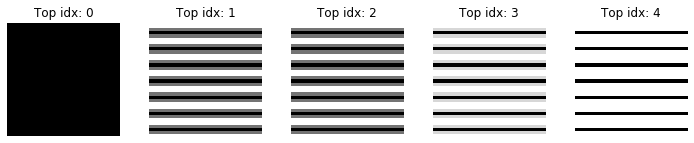

In [28]:
sorted_indices = np.argsort(np.abs(Bt), axis=None)[::-1]#.reshape(Bt.shape)
#sorted_indices = sorted_indices.max() - sorted_indices # Sorted in reverse
ncols = 5

fig = plt.figure(figsize=(2*ncols, 2))

for i in np.arange(ncols):
    ind = np.zeros(np.multiply(*Bt.shape))
    ind[sorted_indices[:i+1]] = 1
    ind = ind.reshape(Bt.shape)
    Atlow = Bt * ind
    Alow = np.fft.irfft2(Atlow)
    ax = plt.subplot(1, ncols, i+1)
    ax.imshow(Alow, cmap="Greys_r")
    ax.axis("off")
    ax.set_title(f"Top idx: {i}")
plt.tight_layout()

In [29]:
xidx, yidx = np.indices(Bt.shape)
xidx.shape, yidx.shape

((600, 301), (600, 301))

In [30]:
np.argsort(np.arange(10))[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64)

In [38]:
import pdb

In [46]:
def animate_fft_reconstruction(img, video_file="fft.mp4"):
    B = img.mean(-1)
    Bt = np.fft.rfft2(B)
    sorted_indices = np.argsort(np.abs(Bt), axis=None)[::-1]#.reshape(Bt.shape)
    max_idx = sorted_indices.shape[0]
    #sorted_indices = sorted_indices.max() - sorted_indices # Sorted in reverse
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        moviewriter = FFMpegFileWriter(fps=10)
        with moviewriter.saving(fig, video_file, dpi=100):
            for i in (np.logspace(0, np.ceil(np.log10(max_idx)), 200)).astype("int"):
                ind = np.zeros(np.multiply(*Bt.shape))
                ind[sorted_indices[:i]] = 1
                ind = ind.reshape(Bt.shape)
                Atlow = Bt * ind
                Alow = np.fft.irfft2(Atlow)
                #ax = plt.subplot(1, ncols, i+1)
                ax.clear()
                ax.imshow(Alow, cmap="Greys_r")
                ax.axis("off")
                ax.set_title(f"Top {i} ({ind.mean()*100.:.3f}%) FFT components")
                moviewriter.grab_frame()
    return video_file

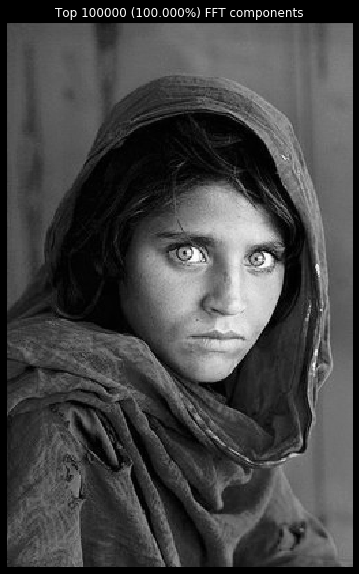

In [47]:
img = plt.imread("C:/Users/shubh/Downloads/Sharbat_Gula.jpg")
video_file = animate_fft_reconstruction(img, video_file="Sharbat_Gula.mp4")
Video(video_file)

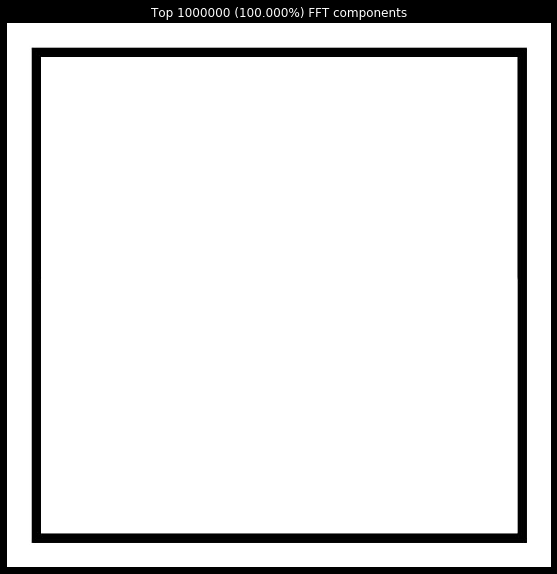

In [48]:
img = plt.imread("C:/Users/shubh/Downloads/square.jpg")
video_file = animate_fft_reconstruction(img, video_file="square.mp4")
Video(video_file)

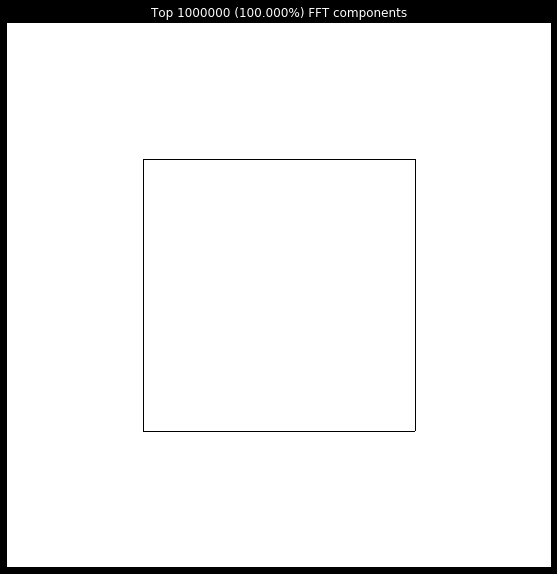

In [49]:
img = np.ones((600, 600, 3))*255
img[150:450, 150] = 0
img[150:450, 450] = 0
img[150, 150:450] = 0
img[450, 150:450] = 0
video_file = animate_fft_reconstruction(img, video_file="single_square_fft.mp4")
Video(video_file)

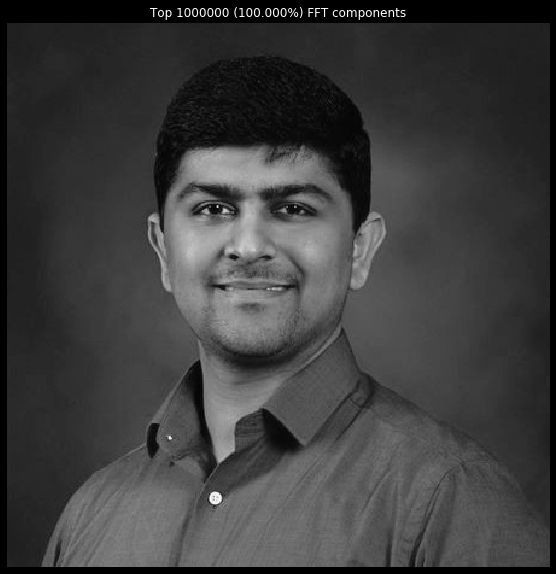

In [50]:
img = plt.imread("C:/Users/shubh/Downloads/shubhanshu.jpg")
video_file = animate_fft_reconstruction(img, video_file="shubhanshu.mp4")
Video(video_file)

In [36]:
from mpl_toolkits.mplot3d import axis3d

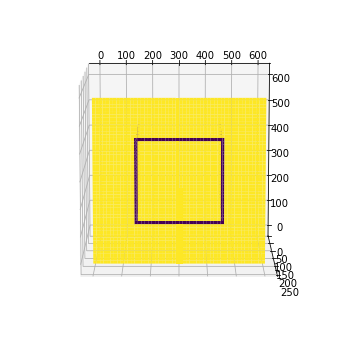

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(np.arange(1, B.shape[1]+1), np.arange(1, B.shape[0]+1))
ax.plot_surface(X, Y, B, cmap="viridis", edgecolor="none")
ax.view_init(100, 270)